In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn import model_selection

# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [2]:
# откройте данные: ваш код здесь

email_data = pd.read_csv('./data/spam_or_not_spam.zip')

email_data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
# рассчитайте частоты для классов : ваш код здесь
email_count = email_data.shape[0]

m_spam = email_data['label'] == 1
spam_email_count = m_spam.sum()
ham_email_count = email_count - spam_email_count

print(f'В датасете {spam_email_count} спам сообщений')
print(f'В датасете {ham_email_count} нормальных сообщений')

В датасете 500 спам сообщений
В датасете 2500 нормальных сообщений


Text(0.5, 1.0, 'Соотньшение спама и не-спама в нашей выборке')

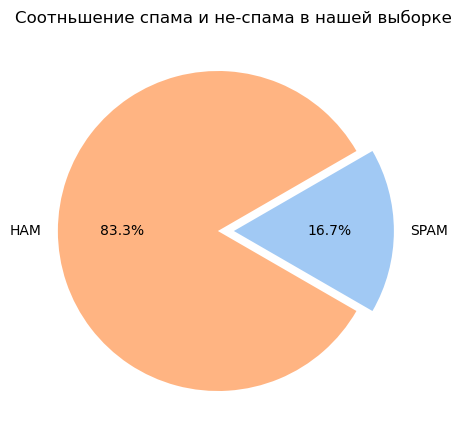

In [4]:
# визуализируйте результат: ваш код здесь

def figax(name, figsize=(7, 4), rowcol=None, axes=[0,0,1,1]):
    fig = plt.figure(name, figsize=figsize)

    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax

_fig, ax = figax('spam_ham_pie')

colors = sns.color_palette('pastel')

ax.pie(
    [spam_email_count, ham_email_count],
    labels=['SPAM', 'HAM'],
    colors=colors,
    explode=[0, 0.1],
    startangle=-30,
    autopct='%1.1f%%',
);
ax.set_title('Соотньшение спама и не-спама в нашей выборке')


## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
def cleanup_email_data(data):
    data.loc[:, 'email'] = data['email'].str.replace('\s+', ' ', regex=True).str.strip()
    m_empty_email = data['email'] == ''
    data.loc[m_empty_email, 'email'] = np.NAN
    data.dropna(inplace=True)

cleanup_email_data(email_data)

print(f'После предобработки осталось {email_data.shape[0]} строк')

После предобработки осталось 2997 строк


Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(email_data['email'])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
print(f'Кол-во признаков в наборе данных после предобработки: {X.shape[1]}')

Кол-во признаков в наборе данных после предобработки: 34116


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
y = email_data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)

(2247, 34116)
(750, 34116)


Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
print(f'Среднее значение целевой переменной по тестовой выборке: {round(y_test.mean(), 3)}')

Среднее значение целевой переменной по тестовой выборке: 0.165


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [12]:
alpha = 0.01

mnb = MultinomialNB(alpha=alpha);
mnb.fit(X_train, y_train);

cnb = ComplementNB(alpha=alpha);
cnb.fit(X_train, y_train);


Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [13]:
def show_metrics_for_model(model, model_name):
    y_test_pred = model.predict(X_test)

    print(f'Метрики модели {model_name}')
    print(f'- Accuracy: {metrics.accuracy_score(y_test, y_test_pred)}')
    print(f'- Precision: {metrics.precision_score(y_test, y_test_pred)}')
    print(f'- Recall: {metrics.recall_score(y_test, y_test_pred)}')
    print(f'- F₁ score: {metrics.f1_score(y_test, y_test_pred)}')


show_metrics_for_model(mnb, 'MultinomialNB')
print('')
show_metrics_for_model(cnb, 'ComplementNB')


Метрики модели MultinomialNB
- Accuracy: 0.9866666666666667
- Precision: 1.0
- Recall: 0.9193548387096774
- F₁ score: 0.9579831932773109

Метрики модели ComplementNB
- Accuracy: 0.988
- Precision: 1.0
- Recall: 0.9274193548387096
- F₁ score: 0.9623430962343097


Нарисуйте ROC-кривую:

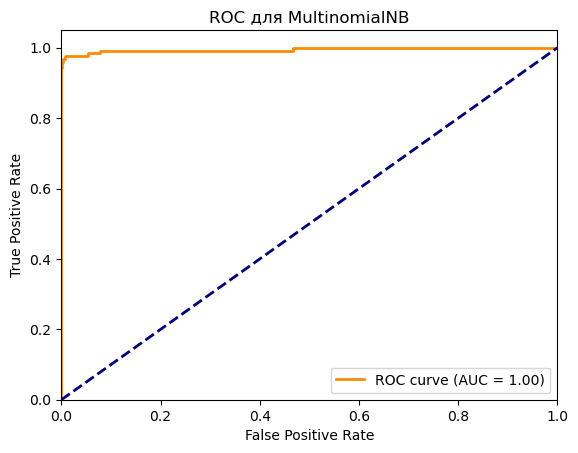

In [14]:
def draw_roc_for_model(model, model_name):
    # Predict probabilities for the test set
    y_scores = model.predict_proba(X_test)[:, 1]

    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores)

    # Compute the area under the ROC curve (AUC)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC для {model_name}')
    plt.legend(loc="lower right")
    plt.show()

draw_roc_for_model(mnb, 'MultinomialNB')

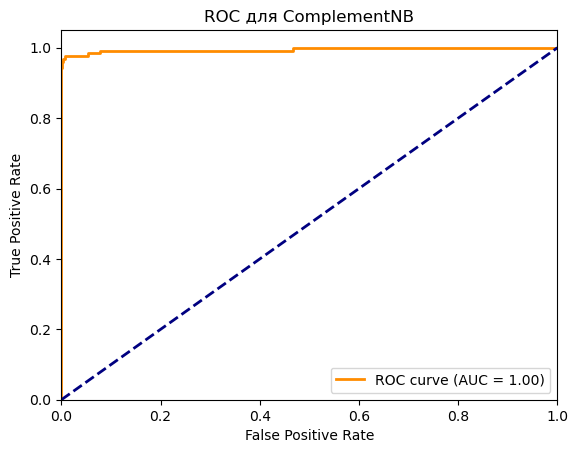

In [15]:
draw_roc_for_model(cnb, 'ComplementNB')

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [16]:
kf = model_selection.KFold(n_splits=5)

for alpha in np.logspace(start=-3, stop=1, num=20):
    cnb = ComplementNB(alpha=alpha);
    cv_metrics = model_selection.cross_validate(
        estimator=cnb,
        X=X_train,
        y=y_train,
        cv=kf,
        scoring='f1', # желаемая метрика
        return_train_score=True,
    )
    f1 = np.mean(cv_metrics['test_score'])
    print(f'alpha = {round(alpha, 2)}, f1: {f1}')


alpha = 0.0, f1: 0.9601391165044051
alpha = 0.0, f1: 0.9630100917262642
alpha = 0.0, f1: 0.9644067904383989
alpha = 0.0, f1: 0.9644956832780809
alpha = 0.01, f1: 0.9659095535241657
alpha = 0.01, f1: 0.9673046970120245
alpha = 0.02, f1: 0.9648980831523526
alpha = 0.03, f1: 0.968041605709016
alpha = 0.05, f1: 0.968041605709016
alpha = 0.08, f1: 0.973513243029372
alpha = 0.13, f1: 0.9709123949835853
alpha = 0.21, f1: 0.9749353795532141
alpha = 0.34, f1: 0.9722761286062915
alpha = 0.55, f1: 0.9710193208978712
alpha = 0.89, f1: 0.9719729022456025
alpha = 1.44, f1: 0.9676660584673773
alpha = 2.34, f1: 0.9344722150732231
alpha = 3.79, f1: 0.8634859791846958
alpha = 6.16, f1: 0.6548955827020698
alpha = 10.0, f1: 0.45845537004344383


Видим, что качество модели зависит от параметра `alpha`